# Salary Analysis
At this notebook I would like to explore the difference on the reported salary from professional developers and non-professional developers (excluding "student" population).

In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

df = pd.read_csv('./stackoverflow/2019.csv')
df.describe()

,Respondent,CompTotal,ConvertedComp,WorkWeekHrs,CodeRevHrs,Age
count,88883.000000,5.594500e+04,5.582300e+04,64503.000000,49790.000000,79210.000000
mean,44442.000000,5.519014e+11,1.271107e+05,42.127197,5.084308,30.336699
std,25658.456325,7.331926e+13,2.841523e+05,37.287610,5.513931,9.178390
min,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000
25%,22221.500000,2.000000e+04,2.577750e+04,40.000000,2.000000,24.000000
50%,44442.000000,6.200000e+04,5.728700e+04,40.000000,4.000000,29.000000
75%,66662.500000,1.200000e+05,1.000000e+05,44.750000,6.000000,35.000000
max,88883.000000,1.000000e+16,2.000000e+06,4850.000000,99.000000,99.000000


## What will be our scope?
From the first part of this Project (notebook: "Project 4 - non-professional developer population") we saw that the top ten countries with most response frequency for our target population are the following:
1. United States
2. Germany
3. United Kingdom
4. India
5. Canada
6. France
7. Australia
8. Netherlands
9. Brazil
10. <s>Italy</s> -> Poland

We will use national minimum wage to normalize one of our views, so we had to exclude "Italy" as it does not have a national minimum wage (source: https://wageindicator.org/salary/minimum-wage/italy). We will substitute for "Poland" as this is the 7th country with most compensation responses and 11th country with most non-professional developers responses.

## How to treat compensation information
When analyzing compensation information, it is impossible to have any understanding on the data if we put different countries together.
At the survey database we have the salary converted and the original figures. Let's use the figures in the country currency to mitigate conversion mistakes by the user.
There is a lot of work to be done on Compensation information. Let's start by removing the rows where there is no answer for CompTotal.

In [4]:
df_sal = df.copy()
df_sal = df_sal.dropna(subset=['CompTotal','CurrencySymbol','CompFreq','Country'])
study_pop = len(df_sal['CompTotal'])

Now we have to put all compensation information at the same annual reference:
* CompTotal to Annual base compensation (CompTotalAnnual) using CompFreq field for the calculation: multiply by 1, the frequency reported was "Yearly", 12, if "Monthly" and 52, if "Weekly".

In [5]:
# substitute CompFreq by the integer multiplier of CompTotal in order to obtain CompTotalAnnual
df_sal['CompFreq'].replace(["Yearly","Monthly", "Weekly"],[1,12, 52],inplace=True)
df_sal['CompFreq'] = df_sal['CompFreq'].astype(int)
df_sal['CompTotalAnnual'] = df_sal['CompFreq'] * df_sal['CompTotal']

Now "CompTotalAnnual" stores the Compensation converted to the annual basis in each countries' own currency.

In [6]:
country = df_sal['Country'].value_counts().reset_index()
country.rename(columns={'index': 'Country', 'Country': 'Count'}, inplace=True)
country['Percent'] = country.Count / study_pop
country.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,Country,Count,Percent
0,United States,"14,981",26.83%
1,United Kingdom,"4,036",7.23%
2,India,"3,999",7.16%
3,Germany,"3,778",6.77%
4,Canada,"2,257",4.04%
5,France,"1,657",2.97%
6,Brazil,"1,400",2.51%
7,Poland,"1,321",2.37%
8,Australia,"1,247",2.23%
9,Netherlands,"1,198",2.15%


For our study, let's take the 10 selected countries.

In [7]:
SalTop = df_sal[(df_sal.Country == 'United States')|(df_sal.Country == 'Germany')|
                 (df_sal.Country == 'United Kingdom')|(df_sal.Country == 'India')|
                 (df_sal.Country == 'Canada')|(df_sal.Country == 'France')|
                 (df_sal.Country == 'Australia')|(df_sal.Country == 'Netherlands')|
                 (df_sal.Country == 'Poland')|(df_sal.Country == 'Brazil')]

In [8]:
SalTop.CurrencySymbol.unique()

array(['USD', 'CAD', 'INR', 'EUR', 'GBP', 'AUD', 'BRL', 'PLN', 'XPF',
       'CHF', 'IRR', 'BZD', 'SEK', 'NZD', 'AFN', 'WST', 'ANG', 'ALL',
       'CNY', 'SAR', 'GNF', 'AMD', 'GGP', 'LKR', 'MKD', 'VND', 'AOA',
       'NGN', 'SGD', 'IMP', 'BHD', 'RUB', 'LSL', 'HKD', 'MMK', 'AED',
       'DKK', 'FJD', 'BMD', 'ARS', 'BSD'], dtype=object)

We can see that some respondents receive salary (or reported a salary) in a non-standard currency. Let's exclude these case.

In [9]:
SalTopClean = SalTop.copy()
indexNames = SalTop[ ((SalTop['Country'] == 'Australia') & (SalTop['CurrencySymbol'] != 'AUD'))|
                     ((SalTop['Country'] == 'Brazil') & (SalTop['CurrencySymbol'] != 'BRL'))|
                     ((SalTop['Country'] == 'Canada') & (SalTop['CurrencySymbol'] != 'CAD'))|
                     ((SalTop['Country'] == 'France') & (SalTop['CurrencySymbol'] != 'EUR'))|
                     ((SalTop['Country'] == 'Germany') & (SalTop['CurrencySymbol'] != 'EUR'))|
                     ((SalTop['Country'] == 'Poland') & (SalTop['CurrencySymbol'] != 'PLN'))|
                     ((SalTop['Country'] == 'Netherlands') & (SalTop['CurrencySymbol'] != 'EUR'))|
                     ((SalTop['Country'] == 'India') & (SalTop['CurrencySymbol'] != 'INR'))|
                     ((SalTop['Country'] == 'United Kingdom') & (SalTop['CurrencySymbol'] != 'GBP'))|
                     ((SalTop['Country'] == 'United States') & (SalTop['CurrencySymbol'] != 'USD'))].index
SalTopClean.drop(indexNames , inplace=True)
SalTopClean.CurrencySymbol.unique()
table = pd.pivot_table(SalTopClean, index=['Country', 'CurrencySymbol'],columns=['Respondent'],
                       aggfunc=np.sum)
table.iloc[0:,0:0]

Country,CurrencySymbol
Australia,AUD
Brazil,BRL
Canada,CAD
France,EUR
Germany,EUR
India,INR
Netherlands,EUR
Poland,PLN
United Kingdom,GBP
United States,USD


Now each country has only entries with compensation information reported with their standard currency. Let's take a look on the countries' distribution after this "cleaning".

In [10]:
country = SalTopClean['Country'].value_counts().reset_index()
country.rename(columns={'index': 'Country', 'Country': 'Count'}, inplace=True)
country['Percent'] = country.Count / len(SalTopClean['Country'])
country.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,Country,Count,Percent
0,United States,"14,966",42.12%
1,United Kingdom,"3,996",11.25%
2,India,"3,888",10.94%
3,Germany,"3,757",10.57%
4,Canada,"2,213",6.23%
5,France,"1,632",4.59%
6,Brazil,"1,364",3.84%
7,Poland,"1,278",3.60%
8,Australia,"1,242",3.50%
9,Netherlands,"1,195",3.36%


To visualize salary it is important to log transform the column as this is a data that is very skewed to the left.

In [11]:
features_log_transformed = pd.DataFrame(data = SalTopClean)
features_log_transformed['sal_log'] = SalTopClean['CompTotalAnnual'].apply(lambda x: np.log(x + 1))

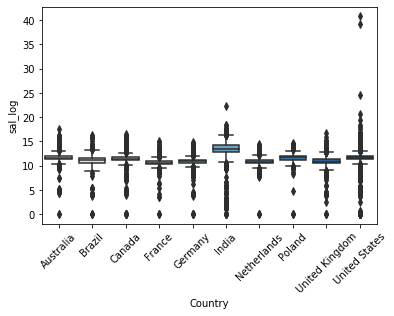

In [12]:
chart = sns.boxplot( x=SalTopClean["Country"], y=SalTopClean["sal_log"], palette="Blues",
                     order=['Australia','Brazil','Canada','France','Germany','India',
                            'Netherlands','Poland','United Kingdom','United States']);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

Even log-transforming the salaries we still don't get a good view. Let's try to normalize the salaries with the country's minimum wage and then log-transform it again (source: https://stats.oecd.org/Index.aspx?DataSetCode=RMW, year used: 2018 /  India: https://tradingeconomics.com/country-list/minimum-wages, considered 250 work days in a year).
From this minimum wage database exploration I noticed that for Brazil, for example, the annual salary reference only multiplied the monthly minimum wage by 12, when the correct would be 13.33. For simplification, I used exactly the reference from the website - even though at least for Brazil I know that it is not accurate.

In [13]:
minwage ={'United States' : 15080, 'United Kingdom' : 16115, 'Netherlands' : 20556,'India': 176*250, 
          'Germany': 17876,'France': 17981.64, 'Canada': 26748.8, 'Brazil':12716.82, 'Australia': 36767,
          'Poland': 25200} 
  
# Add a new column named MinWage with the minimum wage reference
SalTopClean['MinWage'] = SalTopClean['Country'].map(minwage) 
# Add a new column named NMinWage with the equivalent number of minimum wage calculated from CompTotalAnnual
SalTopClean['NMinWage'] = SalTopClean['CompTotalAnnual'] / SalTopClean['MinWage']

Now we have a column ("NMinWage") that stores the multiple of minimum wages each respondent answered as his/her compensation.

We need to identify our population study (non-professional developers) and the population we want to compare it against (professional developers).

In [14]:
mainbranch = SalTopClean['MainBranch'].value_counts().reset_index()
mainbranch.rename(columns={'index': 'Type of developer', 'MainBranch': 'Count'}, inplace=True)
mainbranch['Percent'] = mainbranch.Count / len(SalTopClean['Country'])
mainbranch.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,Type of developer,Count,Percent
0,I am a developer by profession,"32,124",90.41%
1,"I am not primarily a developer, but I write code sometimes as part of my work","3,407",9.59%


Our population if interest is less than 10% of the total entries with compensation information that will be used from now on.

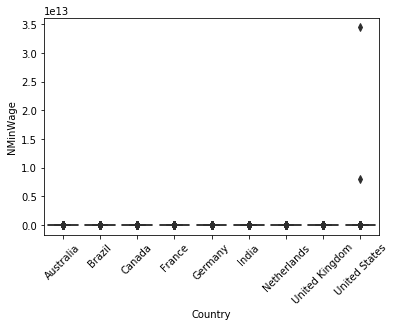

In [15]:
chart = sns.boxplot( x=SalTopClean["Country"], y=SalTopClean["NMinWage"], palette="Blues",
                     order=['Australia','Brazil','Canada','France','Germany','India',
                            'Netherlands','United Kingdom','United States']);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

Some outlier data entries for United States are distorting our visualization. As we are more interested on the normal distribution part of the box plots, let's disregard these outliers.

Let's have a parameter to eliminate dummy compensation entries. In 2018 Jeffrey Bezos' salary was USD 1.7 million, this is 112.7 times the United States minimum wage. As we don't know how many CEOs we have in the database, let's assume our cut reference as 3 times his reference salary. Therefore, NMinWage == 338.2.

(source: https://www.usatoday.com/story/money/business/2018/04/05/highest-paid-ceos-americas-100-largest-companies/488630002/)

In [16]:
# delete all rows that have better multiple of minimum wage than 3 times Jeff Bezos salary in 2018
indexNames = SalTopClean[ (SalTopClean['NMinWage'] >= 338.2) ].index
SalTopClean.drop(indexNames , inplace=True)

In [17]:
mainbranch = SalTopClean['MainBranch'].value_counts().reset_index()
mainbranch.rename(columns={'index': 'Type of developer', 'MainBranch': 'Count'}, inplace=True)
newStudyPop = len(SalTopClean['Country'])
mainbranch['Percent'] = mainbranch.Count / newStudyPop
mainbranch.style.format({'Count': "{:,}", 'Percent': '{:.2%}'})

,Type of developer,Count,Percent
0,I am a developer by profession,"31,759",90.37%
1,"I am not primarily a developer, but I write code sometimes as part of my work","3,384",9.63%


After eliminating salary entries that seemed unrealistic high, we are left with 35,143 entries and the proportion between the two population had a small change.

Now the log-transformation:

In [18]:
NMinWage_transform = pd.DataFrame(data = SalTopClean)
NMinWage_transform['NMinWage_log'] = SalTopClean['NMinWage'].apply(lambda x: np.log(x + 1))

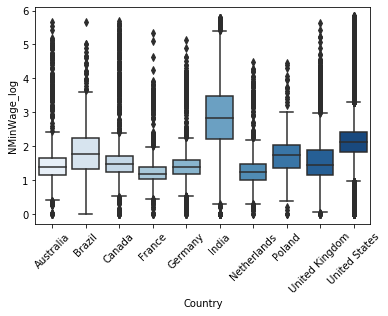

In [19]:
chart = sns.boxplot( x=SalTopClean["Country"], y=SalTopClean["NMinWage_log"], palette="Blues",
                     order=['Australia','Brazil','Canada','France','Germany','India',
                            'Netherlands','Poland','United Kingdom','United States']);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

We still have a lot of outliers (potentially many dummy entries, like the salaries close to zero). However now we can visualize the box, which represents the main population (our normal curve).

Now let's separate our two populations (and do a nicer box plot):

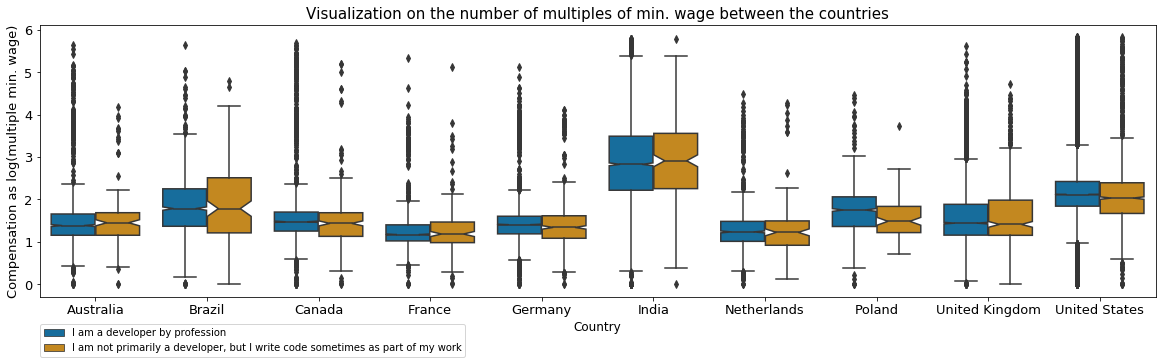

In [20]:
plt.figure(figsize=(20,5))
plot01 = sns.boxplot(x=SalTopClean['Country'], y=SalTopClean["NMinWage_log"], order=['Australia',
                     'Brazil','Canada','France','Germany','India','Netherlands','Poland','United Kingdom',
                     'United States'], hue=SalTopClean['MainBranch'], notch=True, data=SalTopClean, palette='colorblind')
plt.ylabel("Compensation as log(multiple min. wage)", fontsize=13)
plt.xlabel("Country", fontsize=12)
plt.title("Visualization on the number of multiples of min. wage between the countries", loc='center', fontsize = 15)
plt.tick_params('both', labelsize='13')
plt.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.)
plt.show()

(The graph is the log-transformed multiple of minimum wage to facilitate the distribution visualization.)

We can notice that the data base contains a significant number of outliers, represented by the dots plotted above the maximum and below the minimum (potentially, dummy entries).
We can perceive some differences on salary distribution comparing the countries:
* In countries like India and Brazil the normal distribution (represented by the colored box) is larger, indicating a bigger gap in multiples of minimum wage within this snippet of the population;
* On the other end, we have France, Germany, Netherlands and Canada with narrower normal distributions - an indication that in general the respondents' compensation are closer to each other compared to the other countries.
* India has a multiple of minimum wage salaries significantly higher for the surveyed population.

It seems that comparing the two groups (professional developers and non-professional developers) the medians are similar. Let's take a look at this absolute information.

In [21]:
median = pd.pivot_table(SalTopClean, values='NMinWage', index=['Country'], columns=['MainBranch'],
                        aggfunc=np.median)
median.rename(columns={ 'I am a developer by profession': 'Professional Developer',
                       'I am not primarily a developer, but I write code sometimes as part of my work':
                       'Non-professional Developer'}, inplace=True)
median['Perc. higher prof. vs non-prof.'] = median['Professional Developer'] / median['Non-professional Developer']
median.style.format({'Perc. higher prof. vs non-prof.': '{:.2%}'})
df_median = pd.DataFrame(median.to_records())
df_median

,Country,Professional Developer,Non-professional Developer,Perc. higher prof. vs non-prof.
0,Australia,2.991813,3.263796,0.916667
1,Brazil,4.953597,4.954069,0.999905
2,Canada,3.364637,3.200144,1.051402
3,France,2.224491,2.268981,0.980392
4,Germany,3.076751,2.819423,1.091270
5,India,15.909091,17.386364,0.915033
6,Netherlands,2.435980,2.400467,1.014794
7,Poland,4.761905,3.412698,1.395349
8,United Kingdom,3.226807,3.102699,1.040000
9,United States,7.294430,6.631300,1.100000


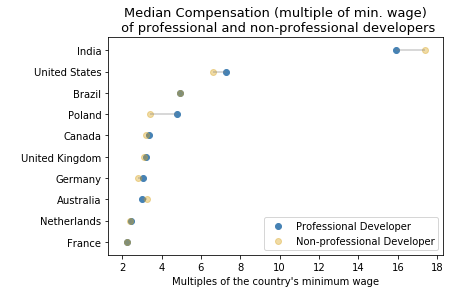

In [22]:
# Reorder it following the values of the first value:
ordered_df = df_median.sort_values(by='Professional Developer')
my_range=range(1,len(df_median.index)+1)

plt.hlines(y=my_range, xmin=ordered_df['Professional Developer'], xmax=ordered_df['Non-professional Developer']
           , color='grey', alpha=0.4)
plt.scatter(ordered_df['Professional Developer'], my_range, color='steelblue', alpha=1, label='Professional Developer')
plt.scatter(ordered_df['Non-professional Developer'], my_range, color='goldenrod', alpha=0.4 , label='Non-professional Developer')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_df['Country'])
plt.title("Median Compensation (multiple of min. wage)\n of professional and non-professional developers", loc='center', fontsize=13)
plt.xlabel("Multiples of the country's minimum wage")
plt.ylabel(' ');


* Brazil, Netherlands and France non-professional developer and professional developer population has similar medians;
* India and Australia non-professional developer respondents have a higher median compared to the professional developers.

India distorts the visualization as the median salary for this population is so much higher than the national minimum wage. So let's take a look at this graph excluding India.

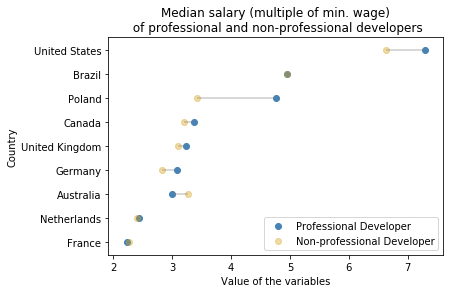

In [104]:
# Reorder it following the values of the first value:
ordered_df = df_median.sort_values(by='Professional Developer')
ordered_df = ordered_df[ordered_df.Country != 'India']
my_range=range(1,len(ordered_df.index)+1)

plt.hlines(y=my_range, xmin=ordered_df['Professional Developer'], xmax=ordered_df['Non-professional Developer']
           , color='grey', alpha=0.4)
plt.scatter(ordered_df['Professional Developer'], my_range, color='steelblue', alpha=1, label='Professional Developer')
plt.scatter(ordered_df['Non-professional Developer'], my_range, color='goldenrod', alpha=0.4 , label='Non-professional Developer')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_df['Country'])
plt.title("Median salary (multiple of min. wage)\n of professional and non-professional developers", loc='center')
plt.xlabel('Value of the variables')
plt.ylabel('Country');